In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [4]:
# Load the training data
charlotte_file_path = '../../Data/Clean/combined/Charlotte_combined.csv'
train_full_df = pd.read_csv(charlotte_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,191953.0,2856.0,503313664.0,178716.688988,181743.275129,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1027.8,-1.2,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
1,2008-05-31,195297.0,2962.0,548334302.0,179423.191080,181545.123492,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1026.8,-2.0,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
2,2008-06-30,198585.0,2963.0,581541816.0,179464.810356,181053.563638,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1026.1,-1.3,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
3,2008-07-31,203829.0,2845.0,595760175.0,179255.088378,180331.749481,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1024.6,-1.1,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
4,2008-08-31,204174.0,2530.0,568197072.0,178753.302909,179487.604132,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1024.7,-0.7,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"


In [5]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [6]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [7]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"CHARLOTTE, NC",1,0,0.0,"Index(['CHARLOTTE, NC'], dtype='object', name=..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,1777.64019,1,0,0.0,"Index([1777.64019], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,91.950313,1,0,0.0,"Index([91.950313], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,39.434102,1,0,0.0,"Index([39.434102], dtype='float64', name='PctB..."


In [8]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [9]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [10]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [11]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [13]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You mig

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.149413,0.150324,1.000204,0.699016,0.252610,0.231673,0.148804,0.070740
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.338575,0.328050,1.068044,0.733053,0.329193,0.335615,0.329643,0.321757


Note for Charlotte dataset
* HistGradientBoost shows the best performance
* Lasso Regression shows high error rates
* Zero Errors in PowerTransformer result is suspicious

In [14]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.148907,0.147204,0.965779,0.667423,0.147304,0.147277,0.146480,0.052988
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.193475,0.191281,0.957018,0.622521,0.192448,0.192021,0.191281,0.162652


Note for Cincinnati dataset
* HistGradientBoost most consistent top performer

In [15]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [16]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You mig

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.186131,0.192171,1.000204,0.740636,0.314468,0.325654,0.188111,0.176676
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.424723,0.426002,1.099318,0.807260,0.509618,0.527946,0.428454,0.344578


Note for Cincinnati dataset
* HistGradientBoost with the best result with lowest RMSE
* PowerTransformer with all zeroes suspicious

In [17]:
# Evaluate RMSE for various regression models and target transformations with all ordinally encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.194322,0.205681,0.965779,0.701512,0.206782,0.206939,0.20182,0.098459
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
QuantileTransformer,0.318789,0.340010,1.005378,0.690351,0.348652,0.347995,0.34001,0.217568


Note:
* HistGradientBoost worse in StandardScaler and PowerTransformer, but better in QuantileTransformer

## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [18]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = StandardScaler()
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [19]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"CHARLOTTE, NC",1,0,0.0,"Index(['CHARLOTTE, NC'], dtype='object', name=..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,1777.64019,1,0,0.0,"Index([1777.64019], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,91.950313,1,0,0.0,"Index([91.950313], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,39.434102,1,0,0.0,"Index([39.434102], dtype='float64', name='PctB..."


In [20]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [21]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.98)


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.923872,0.489295,0.690132,24.878310,0.114275,0.185767,1.713209
numerical__TotalTransactionValue,0.842057,0.557850,0.662233,41.547435,0.202257,0.083860,1.686024
numerical__NUM_JOBS,0.890390,0.111180,0.916687,11.088073,0.099277,0.219265,1.320113
numerical__NewConstructMeanSalePrice,0.490127,0.091201,0.906039,7.579249,0.169812,0.364427,1.115566
numerical__SalesCount,0.485427,0.318664,0.584909,7.789532,0.151601,0.097097,1.052789


* Values need better interpretation, not ideal

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ValueError: num must be an integer with 1 <= num <= 12, not 13

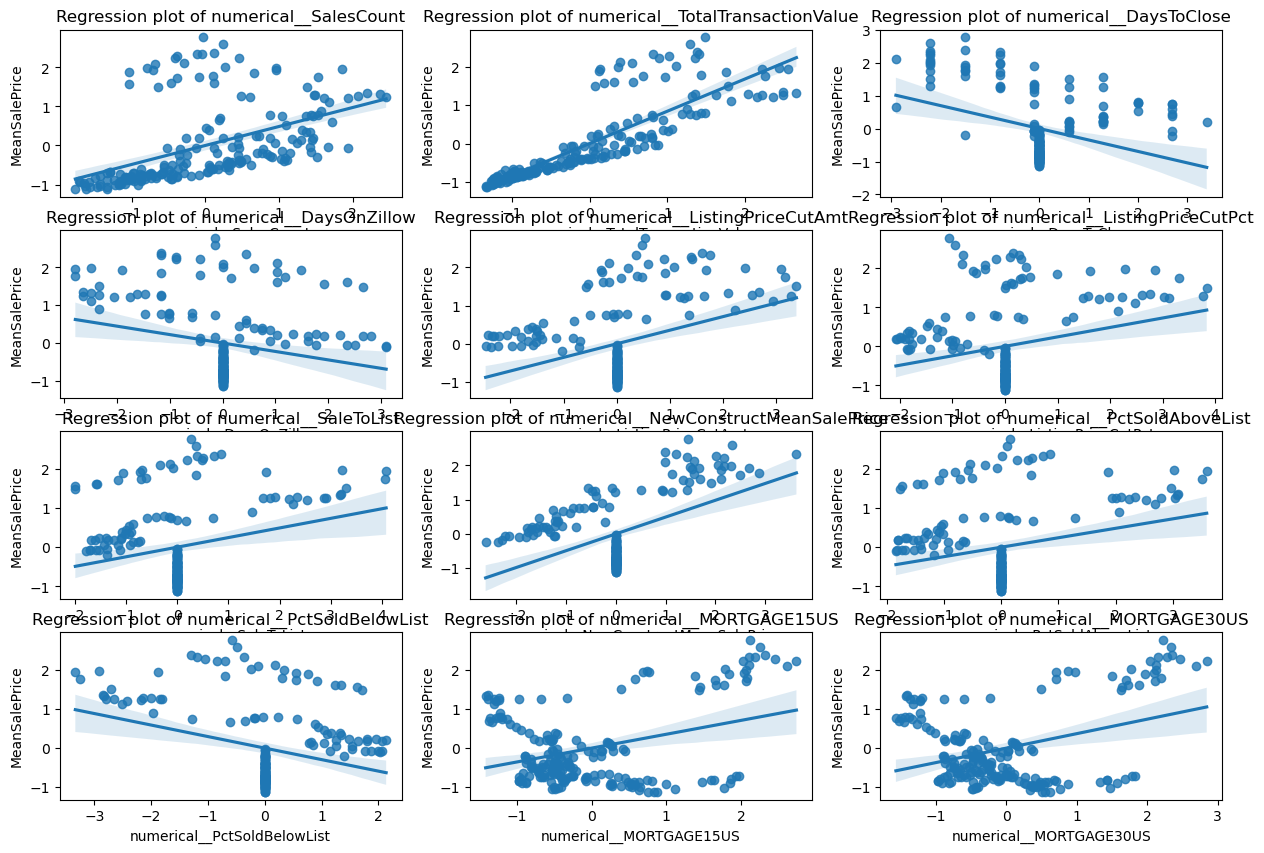

In [22]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


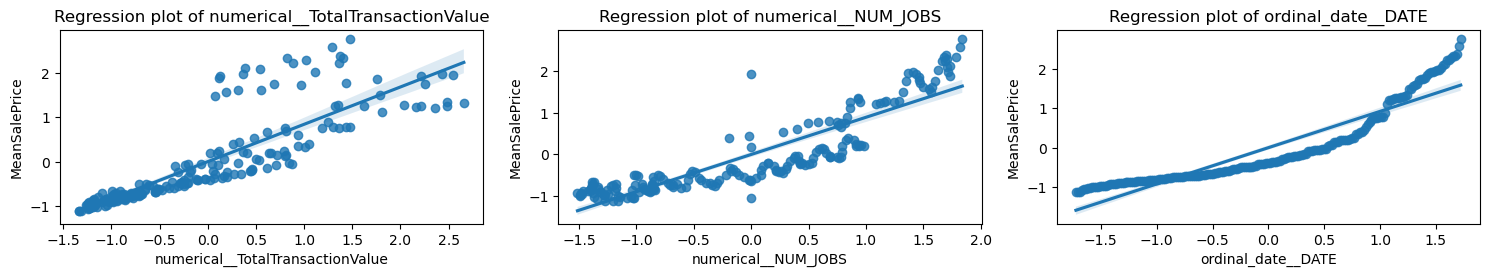

In [23]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.5)

## Perform unsupervised feature selection

Optimal number of features: 8


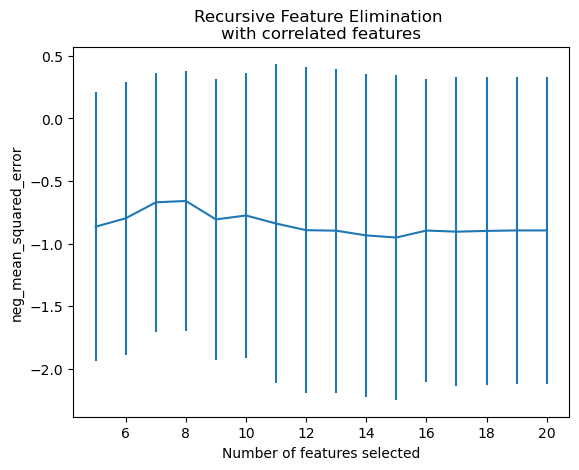

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-2.737867,3.149858,-3.043568,-0.585744,-0.116947,-1.227532,-8.715542,True,1,SalesCount
1,-5.567798,5.252124,-4.681760,-1.628392,-0.173869,-6.188174,-15.166795,True,1,TotalTransactionValue
2,-5.467095,4.927424,-4.611736,-1.603814,-0.181458,-6.743629,-14.194837,False,10,MarketTempIdx
3,-4.526978,5.605260,-0.139348,-0.108695,-0.136276,-8.678997,-13.571571,False,11,DaysToClose
4,-0.864028,1.075714,-0.063225,-0.114035,-0.186697,-1.072282,-2.883898,False,7,DaysOnZillow


In [24]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [25]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['SalesCount' 'TotalTransactionValue' 'PctSoldAboveList'
 'PctSoldBelowList' 'MORTGAGE15US' 'MORTGAGE30US' 'RATE_DIFFERENCE' 'DATE']


Optimal number of features: 3


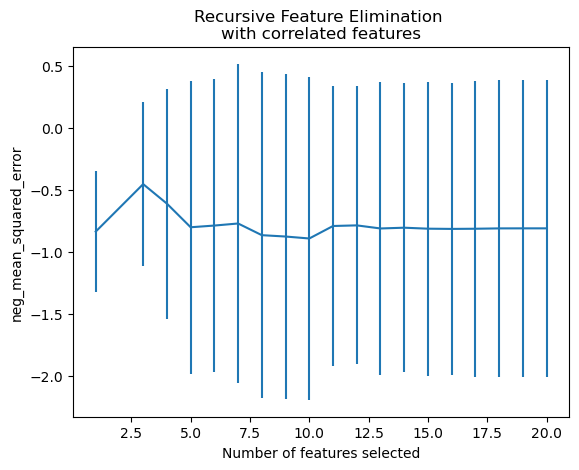

In [26]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=6))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [27]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['PctSoldAboveList' 'PctSoldBelowList' 'DATE']


In [28]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 10 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=6)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1.0
Selected 6 features by forward sequential featureselection in 0.726 seconds
SFS Ridge Selected Features: ['SalesCount', 'TotalTransactionValue', 'PctListingsPriceCut', 'GROWTH_PCT', 'DATE', 'CityName']


In [39]:
# # Remove colinear features from the list of selected features
# # rfe_ridge_selected_features = [rfe_ridge_selected_features]
# rfe_ridge_selected_features = list(rfe_ridge_selected_features).remove('PctListingsPriceCut')
# rfe_ridge_selected_features

In [29]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(1, ['DATE'])

## Perform final EDA with selected features and ordinal columns

In [30]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=array(['PctSoldAboveList', 'PctSoldBelowList', 'DATE'], dtype=object))),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['SalesCount', 'TotalTra...
                                                                              '2011-11-30',
                                                                              '2011-03-31',
                                                                              '2009-11-30',
                                                                              '2011-02-28',
                                                                              '2011-04-30',
                                                                              '2010-01-31',
                                                                              '2010-02-28',
                                                                              '2009-06-30',
                                                                              '2009-10-31',
                                                                              '2011-01-31',
                                                                              '2008-10-31',
                                                                              '2013-02-28',
                                                                              '2010-12-31',
                                                                              '2013-01-31',
                                                                              '2011-10-31',
                                                                              '2010-04-30',
                                                                              '2010-03-31',
                                                                              '2013-03-31', ...]],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['DATE'])])

In [31]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 0.01 (R^2 score:  0.92)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.923872,0.863839,0.000209,1.052235,0.178033,0.983858,2.949603
numerical__PctSoldBelowList,0.294459,1.666830,0.309445,54.507940,0.696910,0.113095,2.771293
numerical__PctSoldAboveList,0.242406,1.510799,0.354965,54.147423,0.694709,0.138681,2.586595


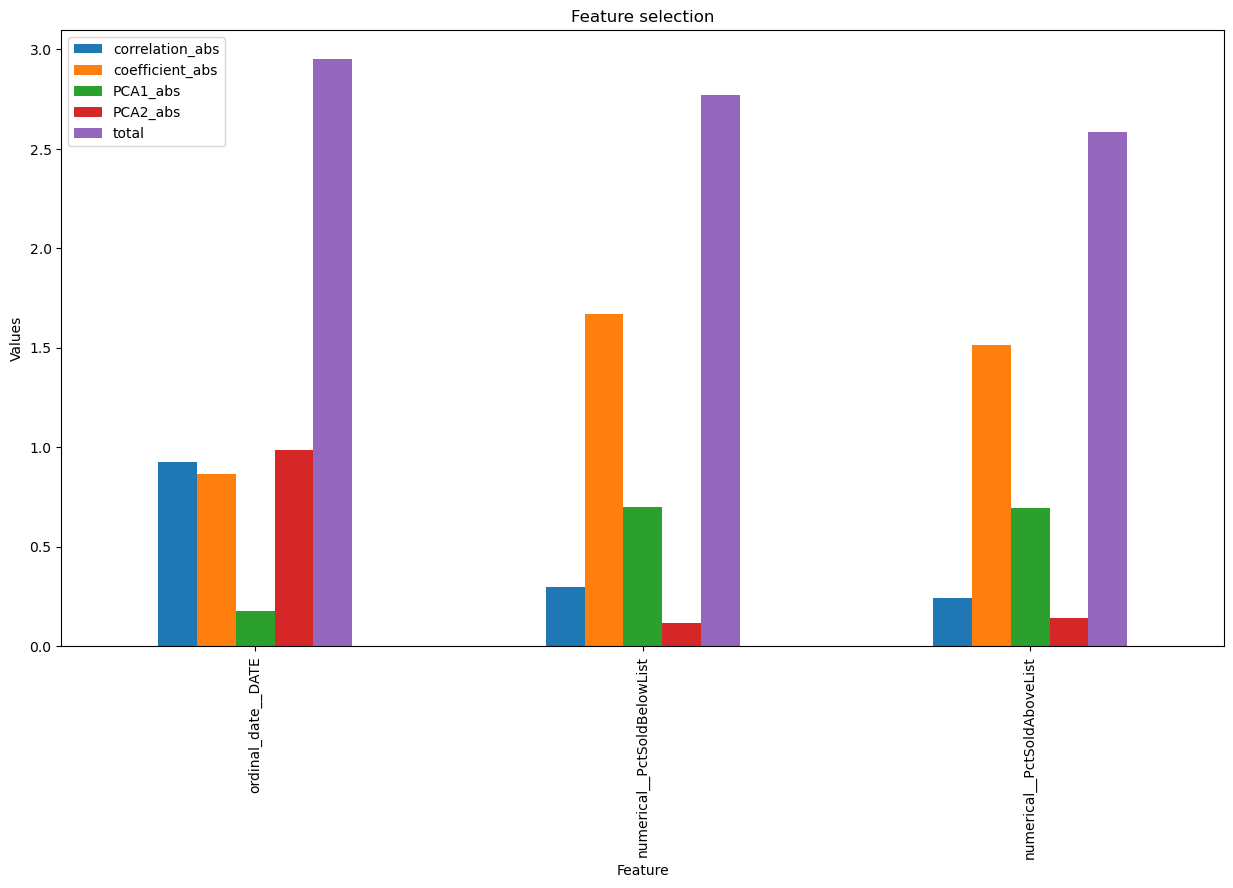

In [32]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [35]:
# Reload the data just to be safe
train_full_df = pd.read_csv(charlotte_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [36]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [37]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 3


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
HistGradientBoost,0.993609,0.010557,0.988674,0.987704,0.869154,0.050767,0.310752,"[0.20246823646085318, -0.8136980547598719, 0.8..."
ElasticNetCV,0.923723,0.079524,0.914684,0.907371,0.869154,0.050767,0.043361,"[0.0832545823585577, -0.8749503895055454, 1.00..."
Ridge Regression,0.916364,0.080325,0.913825,0.906438,0.869154,0.050767,0.010291,"[0.17710437175426053, -0.8823057184769811, 1.0..."
LassoCV,0.924634,0.080799,0.913316,0.905886,0.869154,0.050767,0.048076,"[0.051950177543547194, -0.8720534057445974, 1...."
RidgeCV,0.924821,0.082018,0.912008,0.904465,0.869154,0.050767,0.008448,"[0.032728005276932856, -0.870618986004711, 0.9..."
Linear Regression,0.924823,0.082191,0.911822,0.904264,0.869154,0.050767,0.010327,"[0.030233265019125682, -0.8703791464983875, 0...."


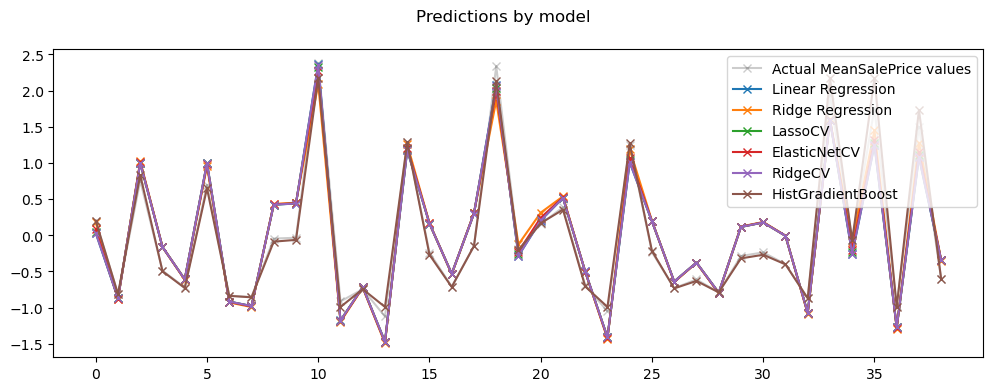

In [38]:
reg.plot_model_evaluations()

In [39]:
# Get the best model
reg.best_model_name

'HistGradientBoost'

## Now use the best model to predict on the test data

In [40]:
# Load test data from a different city
combined_file_path = '../../Data/Clean/combined/all_cities_combined.csv'
test_full_df = pd.read_csv(combined_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [41]:
# Drop target column
combined_file_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [42]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([191921.90057332, 195189.48403135, 198290.43970036, ...,
       422857.30437847, 422857.30437847, 422857.30437847])

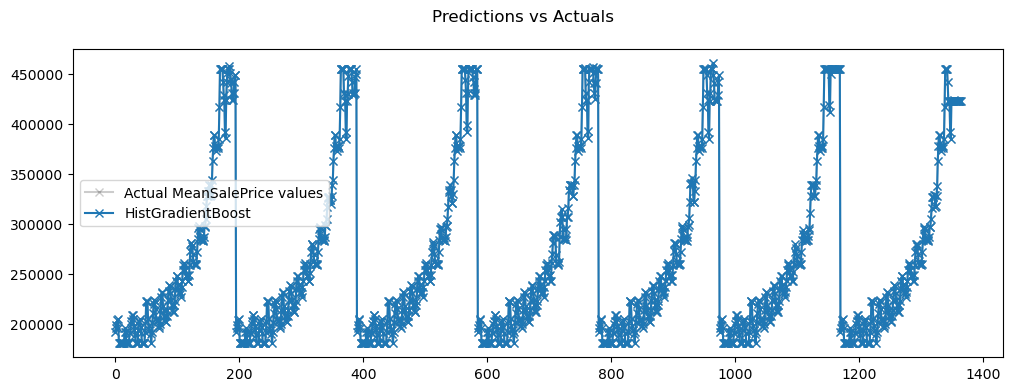

In [45]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions vs Actuals")
ax.plot(
    lr_predictions,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

For handoff:
This is clearly wrong — lr_predictions incorreect usage, not sure how to get what I need within pipeline